In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
sigma_value = 1
epsilon_value = 0.0005
max_episodes_value = 300
num_trials_value = 150

epsilon_entropy = 0.1
k_entropy = 6
k_epsilon_entropy = 6
max_episodes_entropy = 100

In [47]:
def policy(state, theta):
    return 1/(1 + np.exp(-(np.dot(theta, state))))

In [48]:
def dynamics(state, action):
    gravity = 9.8
    force = 10.0
    time_step = 0.02
    cart_mass = 1.0
    pole_mass = 0.1
    rod_len = 1.0

    x, v, theta, theta_dot = state

    app_force = force if (action == 1) else (-force)
    cost = np.cos(theta)
    sin_theta = np.sin(theta)

    theta_acc = (gravity * sin_theta + cost * (-app_force - pole_mass * rod_len * theta_dot**2 * sin_theta) / (cart_mass + pole_mass)) / (rod_len * (4/3 - pole_mass * cost ** 2 / (cart_mass + pole_mass)))
    
    acc = (app_force + pole_mass * rod_len * (theta_dot**2 * sin_theta - theta_acc * cost)) / (cart_mass + pole_mass)
    
    x = x + time_step * v
    theta = theta + time_step * theta_dot
    v = v + time_step * acc
    theta_dot += time_step * theta_acc

    return (x, v, theta, theta_dot)

In [49]:
def episodes(theta):
    state = (0, 0, 0, 0)
    final_reward = 0

    for i in range(2000):
        action_prob = policy(state, theta)
        if np.random.rand() > action_prob:
            action = 0
        else:
            action = 1
        
        new_state = dynamics(state, action)

        if abs(new_state[2]) > 5*np.pi/12 or abs(new_state[0]) > 3 or i >= 2000:
            break
        
        state = new_state
        final_reward = final_reward + 1
    
    return final_reward


In [50]:
def policy_search(sigma, epsilon, max_episodes, num_trials):
    all_gains = []

    for _ in range(num_trials):
        theta = np.random.rand(4)
        episode_gains = []

        for episode_num in range(max_episodes):
            state = np.array([0, 0, 0, 0])
            reward = episodes(theta)
            action_prob = policy(state, theta)

            if np.random.rand() > action_prob:
                action = 0
            else:
                action = 1

            per = np.random.normal(0, sigma, len(theta))
            per_theta = theta + per
            per_reward = episodes(per_theta)

            if per_reward > reward:
                theta = per_theta
                reward = per_reward

            episode_gains.append(reward)

        all_gains.append(episode_gains)

    return all_gains

In [51]:
def entropy_method(epsilon, k, k_epsilon, max_episodes, num_trials):
    all_gains = []

    for _ in range(num_trials):
        theta = np.random.rand(4)
        sigma = 2 * np.eye(4)
        episode_gains = []
        prev_final_reward = float('-inf')
        episode_num = 1

        while episode_num < max_episodes:
            thetas = np.random.multivariate_normal(theta, sigma, k)
            episode_rewards = []

            for i in range(k):
                reward = episodes(thetas[i])
                episode_rewards.append(reward)

            final_reward = np.sum(episode_rewards)
            episode_num += 1

            top_indices = np.argsort(episode_rewards)[-k_epsilon:]
            top_thetas = thetas[top_indices]
            average_theta = np.mean(top_thetas, axis=0)
            sigma_update = np.zeros_like(sigma)

            for i in range(k_epsilon):
                delta = top_thetas[i] - average_theta
                sigma_update += np.outer(delta, delta)

            sigma = (1 / (epsilon + k_epsilon)) * (2 * epsilon * np.eye(4) + sigma_update)
            episode_gains.append(final_reward)
            prev_final_reward = final_reward

        all_gains.append(episode_gains)

    return all_gains

In [52]:
def plot_curve(average_gains, errors, title):
    episodes = range(1, len(average_gains) + 1)
    sns.set_style("darkgrid")
    plt.figure(figsize=(30, 10),  facecolor= "#C1CDCD")
    plt.errorbar(episodes, average_gains, yerr=errors, label=title)
    plt.xlabel('Episodes')
    plt.ylabel('Expected Gain')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(color='black')
    plt.show()

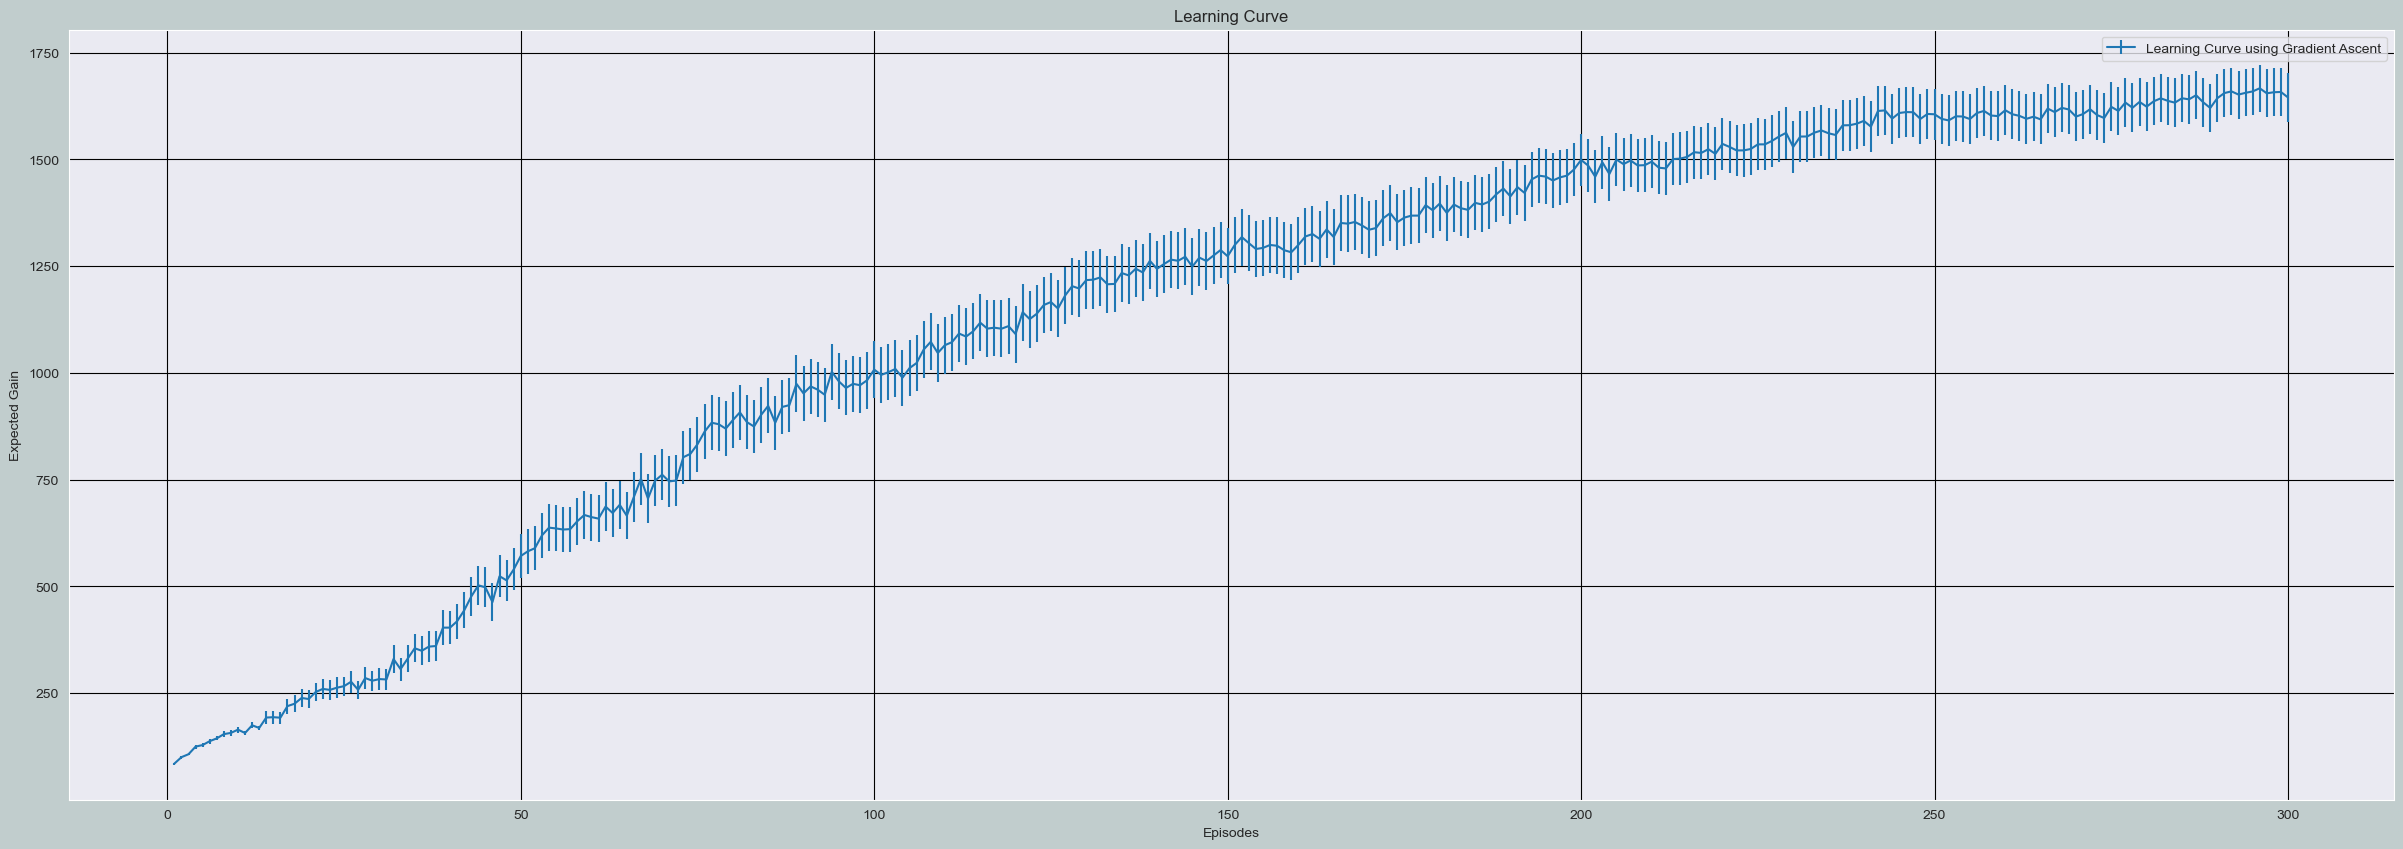

The graph is converging at the Expected gain: 1666.6333333333334


In [53]:
policy_search = policy_search(sigma_value, epsilon_value, max_episodes_value, num_trials_value)
max_len_policy = max(len(episode_gains) for episode_gains in policy_search)
padded_gains_policy = np.array([episode_gains + [0] * (max_len_policy - len(episode_gains)) for episode_gains in policy_search])
expected_gains_policy = np.mean(padded_gains_policy, axis=0)
errors_policy_search = np.std(padded_gains_policy, axis=0) / np.sqrt(num_trials_value)
plot_curve(expected_gains_policy, errors_policy_search, "Learning Curve using Gradient Ascent")
print("The graph is converging at the Expected gain:", np.max(expected_gains_policy, axis=0))


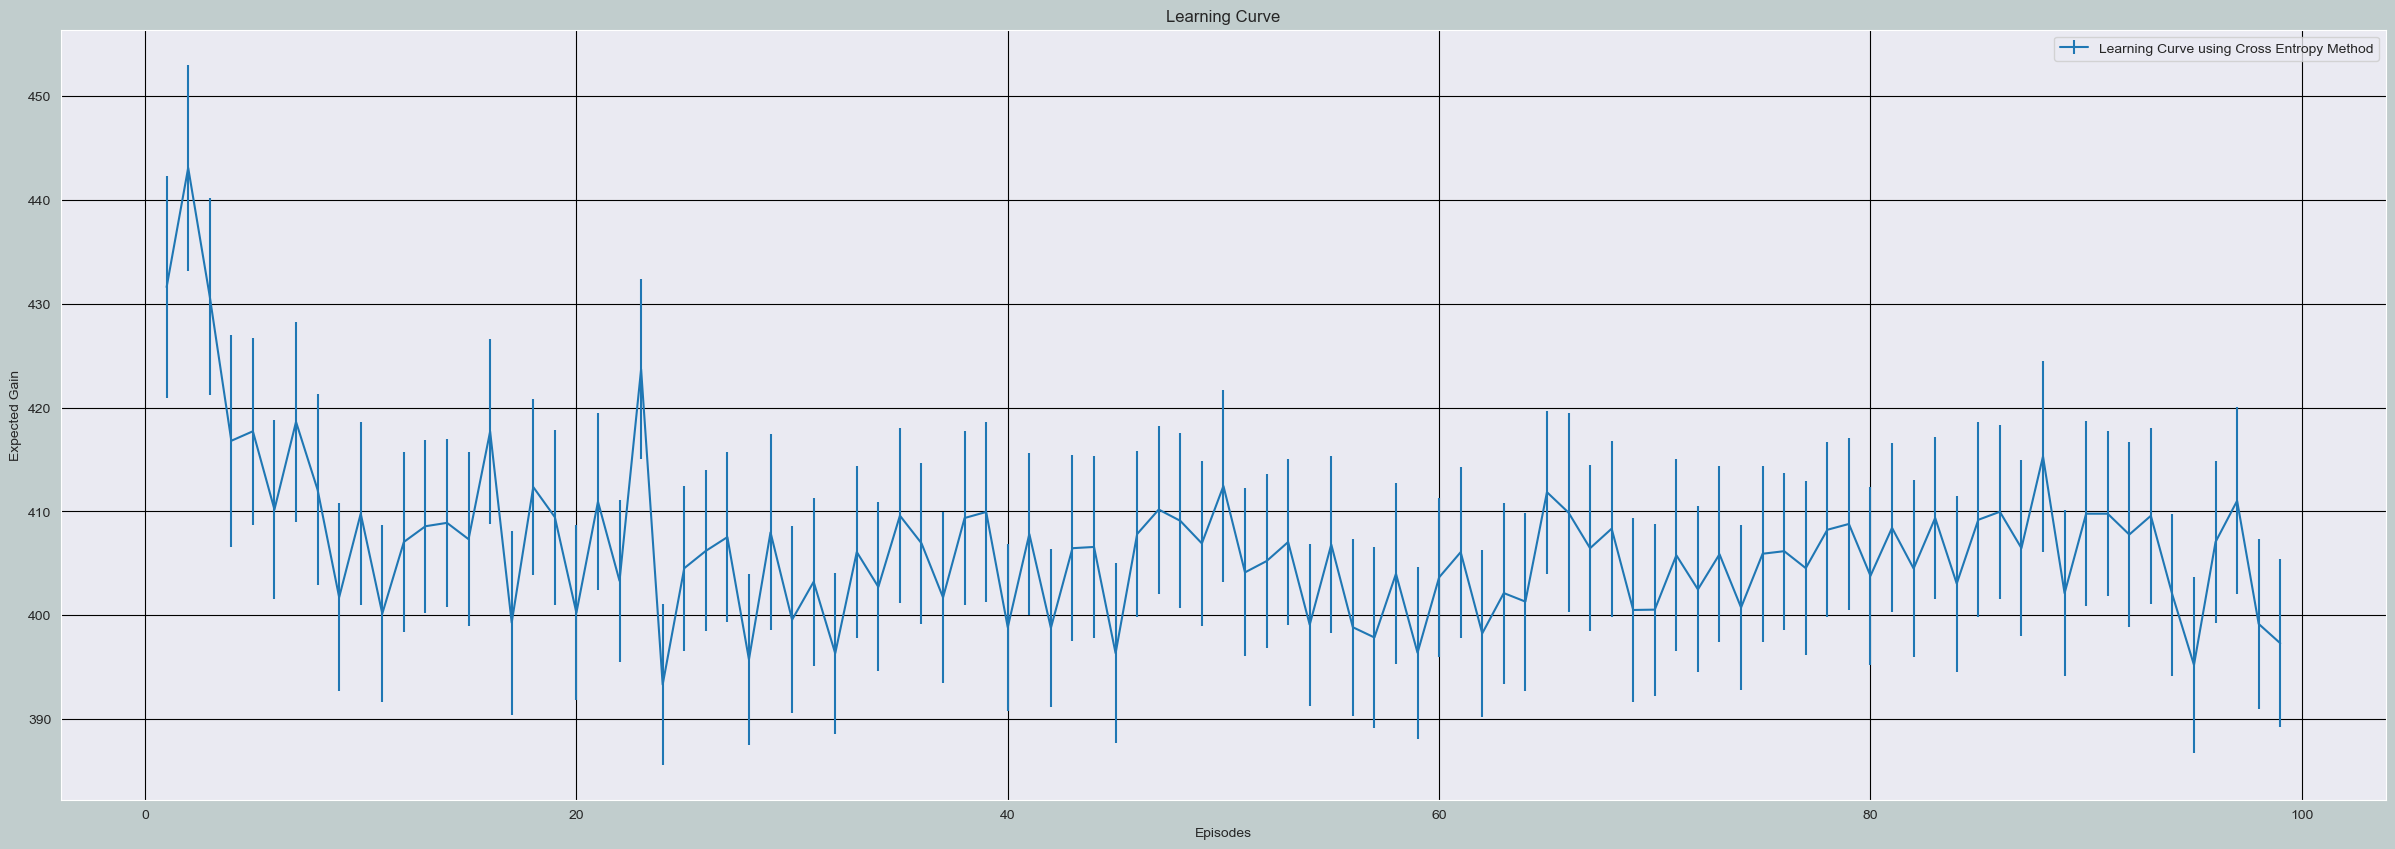

In [54]:

entropy = entropy_method(epsilon_entropy, k_entropy, k_epsilon_entropy, max_episodes_entropy, num_trials_value)
max_len_entropy = max(len(episode_gains) for episode_gains in entropy)
padded_entropy = np.array([episode_gains + [0] * (max_len_entropy - len(episode_gains)) for episode_gains in entropy])
expected_entropy = np.mean(padded_entropy, axis=0)
errors_entropy = np.std(padded_entropy, axis=0) / np.sqrt(num_trials_value)
plot_curve(expected_entropy, errors_entropy, "Learning Curve using Cross Entropy Method")